## First look at health_data
Start with importing the necessary libraries and the data set from the csv file.

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import calendar

from sb_utils import save_file

In [44]:
#Read the LengthOfStay.csv file into the variable health_data
health_data = pd.read_csv('LengthOfStay.csv')

In [ ]:
#Call the info method on health_data to see a summary of the data
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   eid                         100000 non-null  int64  
 1   vdate                       100000 non-null  object 
 2   rcount                      100000 non-null  object 
 3   gender                      100000 non-null  object 
 4   dialysisrenalendstage       100000 non-null  int64  
 5   asthma                      100000 non-null  int64  
 6   irondef                     100000 non-null  int64  
 7   pneum                       100000 non-null  int64  
 8   substancedependence         100000 non-null  int64  
 9   psychologicaldisordermajor  100000 non-null  int64  
 10  depress                     100000 non-null  int64  
 11  psychother                  100000 non-null  int64  
 12  fibrosisandother            100000 non-null  int64  
 13  malnutrition   

In [ ]:
health_data.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,B,3
1,2,5/26/2012,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,A,7
2,3,9/22/2012,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,B,3
3,4,8/9/2012,0,F,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,A,1
4,5,12/20/2012,0,F,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,E,4


In [ ]:
health_data.shape

(100000, 28)

Based on the column names and the data types, here are some first thoughts on what might need to be adjusted:
- rcount (aka the number of readmissions) is an object rather than an integer.  This is probably due to values like 5+, and if so can be fixed by removing the '+' and keeping these numbers as 5.
- the columns 'dialysisrenalendstage' through 'hemo' appear to be integers, but are actually bools with 1 = True and 0 = False.  These columns can be converted to categorical data for more meaningful statistics.
- vdate (aka date of visit) and discharged (aka date of discharge) are objects rather than datetime. This could be handled in one of two ways: 
    1. Remove columns all together since they are superfluous to length of stay 
    2. Remove the discharge column and convert vdate to datetime, which keeps the time of year that the patient was admitted in the data table.  This second option allows for the bias of month of admission to be kept in the model for now.  

Before addressing these issues, I'll look at the distribution of missing values in health_data.

In [ ]:
#Calculate the percent of values that are missing in each column.
missing = pd.concat([health_data.isnull().sum(), 100 * health_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing = missing.sort_values(by='count', ascending=False)
print(missing)

                            count    %
eid                             0  0.0
vdate                           0  0.0
rcount                          0  0.0
gender                          0  0.0
dialysisrenalendstage           0  0.0
asthma                          0  0.0
irondef                         0  0.0
pneum                           0  0.0
substancedependence             0  0.0
psychologicaldisordermajor      0  0.0
depress                         0  0.0
psychother                      0  0.0
fibrosisandother                0  0.0
malnutrition                    0  0.0
hemo                            0  0.0
hematocrit                      0  0.0
neutrophils                     0  0.0
sodium                          0  0.0
glucose                         0  0.0
bloodureanitro                  0  0.0
creatinine                      0  0.0
bmi                             0  0.0
pulse                           0  0.0
respiration                     0  0.0
secondarydiagnosisnonicd9

There are no missing data points in this data set.  

What about duplicates?  All the rows have unique patient identifiers (eid column is 1 to 100,000).  Just in case, I'll see if other rows match with other values.

In [ ]:
#Find duplicated rows allowing for different patient ids.
dupes = health_data[health_data.duplicated(subset=health_data.columns.drop('eid'), keep=False)]
print(dupes)
#Find duplicated patient ids.
dupes_eid = health_data['eid'].value_counts()
print(dupes_eid.head())

Empty DataFrame
Columns: [eid, vdate, rcount, gender, dialysisrenalendstage, asthma, irondef, pneum, substancedependence, psychologicaldisordermajor, depress, psychother, fibrosisandother, malnutrition, hemo, hematocrit, neutrophils, sodium, glucose, bloodureanitro, creatinine, bmi, pulse, respiration, secondarydiagnosisnonicd9, discharged, facid, lengthofstay, readmission_cat, readmission_int]
Index: []

[0 rows x 30 columns]
eid
99984    1
99983    1
99982    1
99981    1
99980    1
Name: count, dtype: int64


There are no duplicated rows in this data set.  Now it's time to move on to the other issues we found. 

1. Make categorical data a categorical data type.
2. Convert rcount to integer by removing non-numeric characters.
3. Delete 'discharged' column and convert 'vdate' to datetime.

## Fix columns with incorrect data type
### Step#1 - Make categorical columns adhere to a categorical data type

In [45]:
# categorical_cols is list of all the columns which are appear numeric, but are actually categorical.
# First see if there are any values other than 0 or 1.
categorical_cols = ['dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother', 'malnutrition', 'hemo']
for col in categorical_cols:
    print(health_data[col].unique())


[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [46]:
#Since all columns have no missing values and no unexpected values, convert each to a bool using a loop.
for col in categorical_cols:
    health_data[col] = health_data[col].astype('category')
print(health_data.head())
print(health_data.info())

   eid       vdate rcount gender dialysisrenalendstage asthma irondef pneum  \
0    1   8/29/2012      0      F                     0      0       0     0   
1    2   5/26/2012     5+      F                     0      0       0     0   
2    3   9/22/2012      1      F                     0      0       0     0   
3    4    8/9/2012      0      F                     0      0       0     0   
4    5  12/20/2012      0      F                     0      0       0     1   

  substancedependence psychologicaldisordermajor  ...     glucose  \
0                   0                          0  ...  192.476918   
1                   0                          0  ...   94.078507   
2                   0                          0  ...  130.530524   
3                   0                          0  ...  163.377028   
4                   0                          1  ...   94.886654   

  bloodureanitro creatinine        bmi pulse  respiration  \
0           12.0   1.390722  30.432418    96     

In [ ]:
print(health_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   eid                         100000 non-null  int64   
 1   vdate                       100000 non-null  object  
 2   rcount                      100000 non-null  object  
 3   gender                      100000 non-null  object  
 4   dialysisrenalendstage       100000 non-null  category
 5   asthma                      100000 non-null  category
 6   irondef                     100000 non-null  category
 7   pneum                       100000 non-null  category
 8   substancedependence         100000 non-null  category
 9   psychologicaldisordermajor  100000 non-null  category
 10  depress                     100000 non-null  category
 11  psychother                  100000 non-null  category
 12  fibrosisandother            100000 non-null  category
 13  

The columns are now converted to category data type.

While we are looking at categorical data, the gender column could also be made categorical.

In [47]:
health_data['gender'].unique()

array(['F', 'M'], dtype=object)

In [48]:
health_data['gender'] = health_data['gender'].astype('category')
health_data['gender'].dtype

CategoricalDtype(categories=['F', 'M'], ordered=False, categories_dtype=object)

In [113]:
percent_female = health_data['gender'].eq('F').mean() * 100 
print(f"{percent_female}% of patients are female, {100-percent_female}% of patients are male.")

57.643% of patients are female, 42.357% of patients are male.


We hav successfully changed the gender column to categorical.  In addition, we see that 57.6% of patients are female, which is likely statistically different from the general population, suggesting that women are admitted more frequently than men.  There are many reasons why this could be true, so we should keep this in mind during EDA and look at the distribution of data by gender.

Now, we will look at the other categorical columns to see the percentage of patients that have each of these conditions.

In [ ]:
#make df with the percent_True for each categorical column
cat_summary = pd.DataFrame({
    'column': categorical_cols,
    'percent': [health_data[col].eq(1).mean() * 100 for col in categorical_cols]
})
cat_summary.set_index('column', inplace=True)
print(cat_summary)

                            percent
column                             
dialysisrenalendstage         3.642
asthma                        3.527
irondef                       9.494
pneum                         3.945
substancedependence           6.306
psychologicaldisordermajor   23.904
depress                       5.166
psychother                    4.939
fibrosisandother              0.479
malnutrition                  4.948
hemo                          8.000


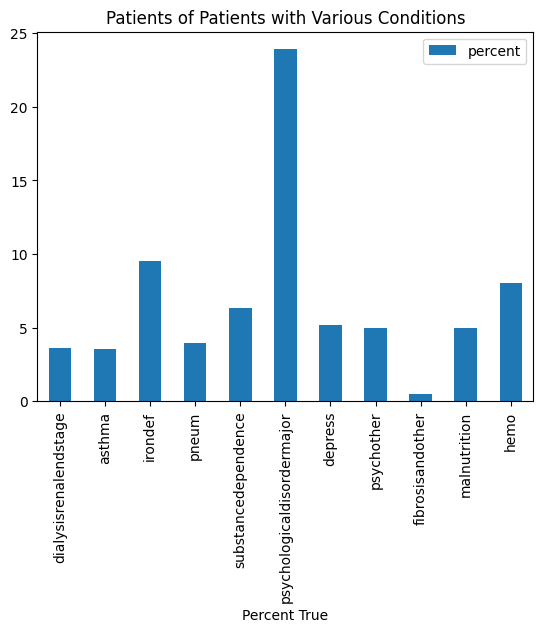

In [ ]:
#plot cat_summary to visualize the percentages
cat_summary.plot(kind='bar')
plt.xlabel("Categorical Columns")
plt.xlabel("Percent True")
plt.title("Patients of Patients with Various Conditions")
plt.show()

We can see the major phychological disorders are much more common than other conditions, while fiborsis (and other) is the least common.  Maybe phychological disorders are a very common cause for inpatient admission, while other conditions can be treated as outpatient unless very serious?  During EDA, we will look to see if phych disorders correlate with length of stay.

## Step#2 - Convert rcount to integer by removing non-numeric characters.

We saw the there was a 5+ is the rcount column, which may be why this column is not coming up as an interger.  First, I will look at the unique values in rcount.

In [49]:
health_data['rcount'].unique()

array(['0', '5+', '1', '3', '4', '2'], dtype=object)

It looks like the 5+ is in fact the issue. I see two ways to handle this:
1. The simple solution would be to remove the '+' and keep these values as 5, then convert the column to an integer.  This has the benefit of keeping the data numeric, which allows for more subtle statistics, but has the downside of losing the information communicated by '+'.  Some patients would have come in more than 5 times, and this reality would make our statistics inaccurate.
2. Create a categorical column with 5+ = Many (5+), 3-4 = Some (3-4), 1-2 = Few (1-2), and 0 = None.  This solves the porblem of keeping the possibility of more than 5 visits, but loses some of the definition within the data.

Due to my inexperience and for the sake of practice, I will do both.  I think that option #1 is the better option, but I will get confirmation and decide which to keep in the next unit.

In [50]:
# Make new column with the readmission categories.
readmission_categories = {'5+':'5+', 4:'3-4', '4':'3-4', 3:'3-4', '3':'3-4', 2:'1-2', '2':'1-2', 1:'1-2', '1':'1-2', 0:'0', '0':'0'}
health_data['readmission_cat'] = health_data['rcount'].replace(readmission_categories)

In [51]:
# Make new column with the readmission counts as integers.
health_data['readmission_int'] = health_data['rcount'].str.replace ('+', '').astype(int)

In [52]:
#Confirm successful conversion to integer
print(health_data['readmission_int'].unique())
print(health_data['readmission_int'].dtype)

[0 5 1 3 4 2]
int64


In [53]:
#Remove the old rcount column
health_data_mod = health_data.drop('rcount', axis=1)
print(health_data_mod.head())

   eid       vdate gender dialysisrenalendstage asthma irondef pneum  \
0    1   8/29/2012      F                     0      0       0     0   
1    2   5/26/2012      F                     0      0       0     0   
2    3   9/22/2012      F                     0      0       0     0   
3    4    8/9/2012      F                     0      0       0     0   
4    5  12/20/2012      F                     0      0       0     1   

  substancedependence psychologicaldisordermajor depress  ... creatinine  \
0                   0                          0       0  ...   1.390722   
1                   0                          0       0  ...   0.943164   
2                   0                          0       0  ...   1.065750   
3                   0                          0       0  ...   0.906862   
4                   0                          1       0  ...   1.242854   

         bmi pulse respiration  secondarydiagnosisnonicd9  discharged  facid  \
0  30.432418    96         6.5

### Step#3: Delete 'discharged' column and convert 'vdate' to datetime.

Have both the admission/discharge dates and the length of stay is repetitive.  However, we don't want to just delete both the admission and discharge columns as there is potentially useful information in the month or year that the patient was admitted.  Instead, the plan is as follows:
1. Delete the discharge date column as it has adds no information to the table.
2. Convert the vdate (date of visit) to datetime.
3. Determine the length of time this data set covers.  Is it more than one year?
4. Extract the month into a new column.  If the data set covers more than one year, so the same with the year.
5. Visualize the month (and maybe year) of admission accross patients.

Note: The reason I'm looking at month of admission is that the conditions within the hospital and the larger environment change with season.  Patients outcomes might vary seasonally (we don't know the location of the hospital - what if it's somewhere where winters are harsh?). Also, teaching hospitals get new interns and residents in July.  Could inexperienced caregivers lead to worse patient outcomes?  I think the connection is worth investigating.

In [ ]:
# Drop discharged date column
health_data_mod = health_data_mod.drop('discharged', axis=1)

In [ ]:
#Convert to datetime
health_data_mod['admission_date'] = pd.to_datetime(health_data_mod['vdate'])
print(health_data_mod['admission_date'].max())
print(health_data_mod['admission_date'].min())

2013-01-01 00:00:00
2012-01-01 00:00:00


In [62]:
health_data_2013 = health_data_mod[health_data_mod['admission_date'].dt.year == 2013]
print(health_data_2013.shape)

(263, 29)


In [66]:
health_data_jan2012 = health_data_mod[(health_data_mod['admission_date'].dt.year == 2012) & (health_data_mod['admission_date'].dt.month == 1)]
print(health_data_jan2012.shape)

(8337, 29)


The health_data dataset covers essentially one year, except it also includes the first day of 2013. I see two potential solutions:
1. The patients in 2013 account for 0.26% of the total patients. We can delete the rows and only look at patients in 2012.
2. Data is data. Add a year column for these 263 patients.

I'm going to go with option 2 for now, mostly for the sake of practice and because I don't like deleting data unecessarily. 

In [74]:
health_data_mod['admission_month'] = health_data_mod['admission_date'].dt.month
health_data_mod['admission_year'] = health_data_mod['admission_date'].dt.year
health_data_sort = health_data_mod.sort_values(by=['admission_date'])
health_data_sort = health_data_sort.drop('vdate', axis=1)

In [75]:
health_data_sort.head()

,eid,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,...,pulse,respiration,secondarydiagnosisnonicd9,facid,lengthofstay,readmission_cat,readmission_int,admission_date,admission_month,admission_year
82814,82815,M,0,0,0,0,0,0,0,0,...,92,6.5,0,B,2,0,0,2012-01-01,1,2012
99367,99368,M,0,0,1,0,0,0,0,0,...,76,6.4,5,C,3,0,0,2012-01-01,1,2012
91181,91182,M,0,0,0,0,0,0,0,0,...,66,7.2,1,B,1,0,0,2012-01-01,1,2012
83266,83267,M,0,0,1,0,0,0,0,0,...,61,6.0,3,C,3,0,0,2012-01-01,1,2012
2955,2956,F,0,0,0,0,0,0,0,0,...,71,6.5,1,B,8,5+,5,2012-01-01,1,2012


We can now remove the admission date, as it's redundant.

In [76]:
health_data_sort = health_data_sort.drop('admission_date', axis=1)

Now plot the number of patients per month in 2012.  We have to remove the 2013 patients since it's only one day, not a full month.

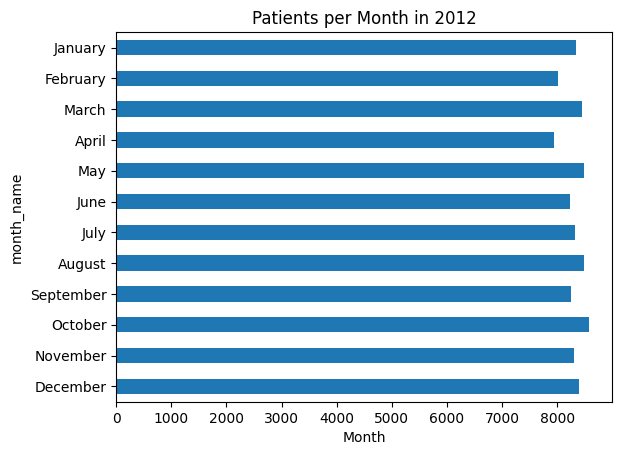

In [87]:
#Remove 2013 patients
health_data_2012 = health_data_sort[health_data_sort['admission_year']== 2012].copy()
#Add column with month name for plotting the months in order
health_data_2012['month_name'] = health_data_2012['admission_month'].apply(lambda x: calendar.month_name[x])
month_order = list(calendar.month_name[1:])
# Set the month order
health_data_2012['month_name'] = pd.Categorical(health_data_2012['month_name'], categories=month_order, ordered=True)
#Count patients per month
month_counts = health_data_2012['month_name'].value_counts().sort_index(ascending=False)
#Make the plot
month_counts.plot(kind='barh')
plt.xlabel("Number of Patients")
plt.xlabel("Month")
plt.title("Patients per Month in 2012")
plt.show()

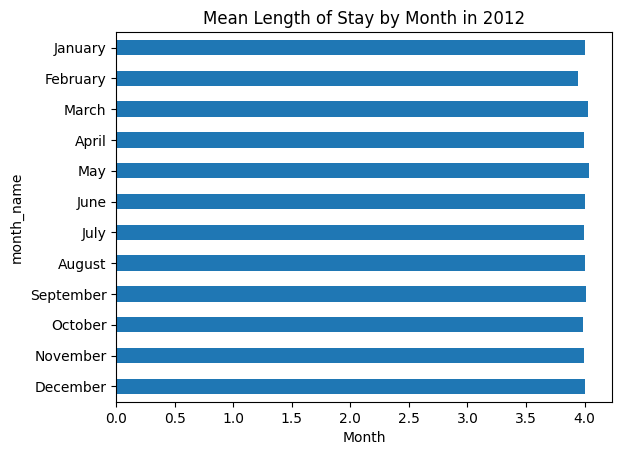

In [89]:
health_data_grouped_LoS = health_data_2012.groupby('month_name', observed=False)['lengthofstay'].mean().sort_index(ascending=False)
health_data_grouped_LoS.plot(kind='barh')
plt.xlabel("Days")
plt.xlabel("Month")
plt.title("Mean Length of Stay by Month in 2012")
plt.show()

The number of patients and mean length of stay looks pretty consistent accross different months.  I will look if other test results change by month in the EDA, but for now it looks like months of admission is not a meaningful variable in this project.  

## Numerical Columns

Finally, we will look at the summary statistcs for the for the remaining numerical columns.

In [119]:
numerical_cols = ['hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration', 'secondarydiagnosisnonicd9']
health_data_sort['pulse'].describe()
num_summary = pd.DataFrame()
for col in numerical_cols:
    stats = health_data_sort[col].describe()
    stats.name = col
    num_summary = pd.concat([num_summary, stats.to_frame().T])
print(num_summary)

                              count        mean        std         min  \
hematocrit                 100000.0   11.975939   2.031792    4.400000   
neutrophils                100000.0   10.177455   5.353131    0.100000   
sodium                     100000.0  137.891397   2.999669  124.912632   
glucose                    100000.0  141.963384  29.992996   -1.005927   
bloodureanitro             100000.0   14.097185  12.952454    1.000000   
creatinine                 100000.0    1.099350   0.200262    0.219770   
bmi                        100000.0   29.805759   2.003769   21.992683   
pulse                      100000.0   73.444720  11.644555   21.000000   
respiration                100000.0    6.493768   0.568473    0.200000   
secondarydiagnosisnonicd9  100000.0    2.123310   2.050641    0.000000   

                                  25%         50%         75%         max  
hematocrit                  10.900000   11.900000   12.900000   24.100000  
neutrophils                  7.70

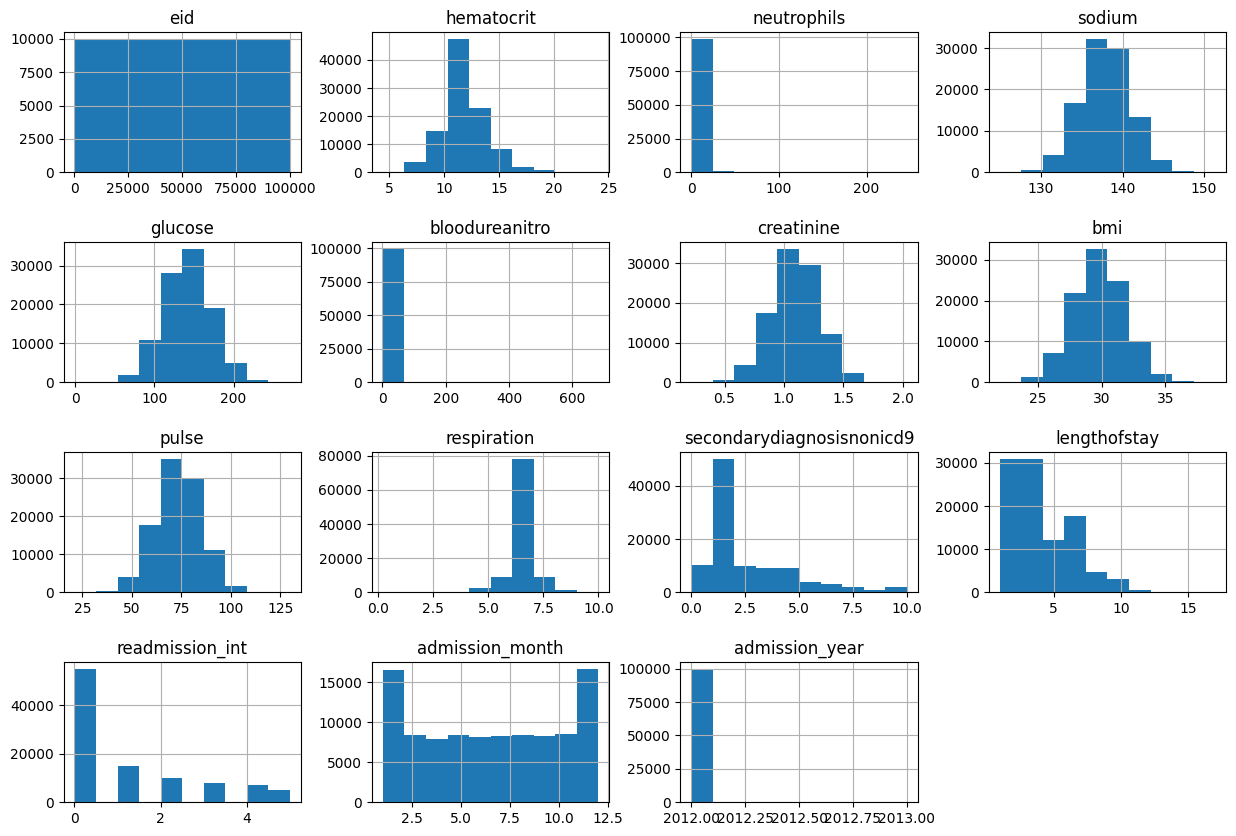

In [125]:
health_data_sort.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5);

The one metric which jumps out to me is blood urea nitrogen (BUN).  The mean and standard deviation are similar and the max value is 682 compared to a mean of 14!  It looks like the BUN can spike quite high, possibly in very sick patients. Secondary diagnoses follows a similar pattern, but the distribution looks fine. 

When reviewing the distributions, we see that all look as expected except for BUN and neutrophils:
- BUN: A quick Google search says that BUN is usually 7-20 mg/dl with dangerous levels at 50 or 100+, depending on the source.  The highest reported level I could find was 298.  This suggests that the max value of 682.5 is an error.  We'll take a closer look.
- Neutrophils: Very high neutrophil levels is consistent with a condition called neutrophilia.  

In [136]:
BUN_high = health_data_sort[health_data_sort['bloodureanitro'] > 300]
print(BUN_high[['bloodureanitro', 'dialysisrenalendstage']].head(20))
print(len(BUN_high))
BUN_percent = len(BUN_high)/len(health_data_sort)*100
print(BUN_percent)
print(BUN_high['bloodureanitro'].corr(BUN_high['dialysisrenalendstage']))

       bloodureanitro dialysisrenalendstage
39674      360.000000                     1
45569      470.000000                     0
82323      313.500000                     0
49068      418.000000                     1
77726      418.000000                     1
77834      302.500000                     0
96860      335.666667                     0
91860      335.666667                     0
53948      311.500000                     1
20518      302.500000                     0
97155      321.500000                     1
74227      470.000000                     0
85039      447.000000                     1
28405      474.000000                     0
5090       682.500000                     0
20410      418.000000                     1
82881      338.250000                     0
90039      447.000000                     1
38876      413.333333                     0
92155      321.500000                     1
38
0.038
-0.20200027714942909


These results are surprising, with 38 rows that have extremely high BUN.  Given that this is out of 100,000 patients, I can beleive that 38 mistakes happened, but it's less convincing that if there were only one or two.  I'ts also very odd that these patients aren't all in end stage renal failure, which would be a clear requirement of haveing BUN that high. I will try removing the rows with BUN over 300 and looking at the new distribution.

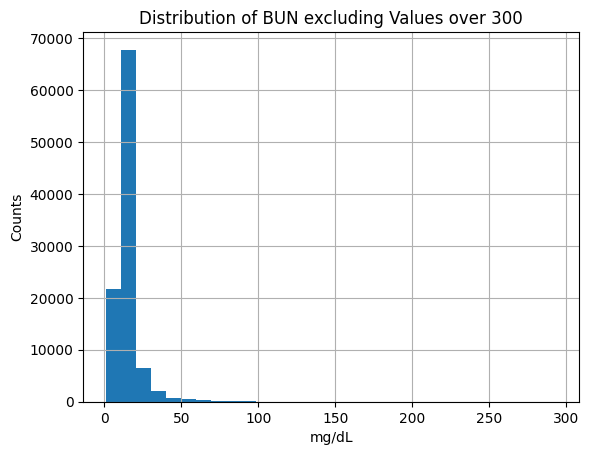

In [150]:
health_data_sort.bloodureanitro[health_data_sort.bloodureanitro < 300].hist(bins=30)
plt.xlabel('mg/dL')
plt.ylabel('Counts')
plt.title('Distribution of BUN excluding Values over 300');

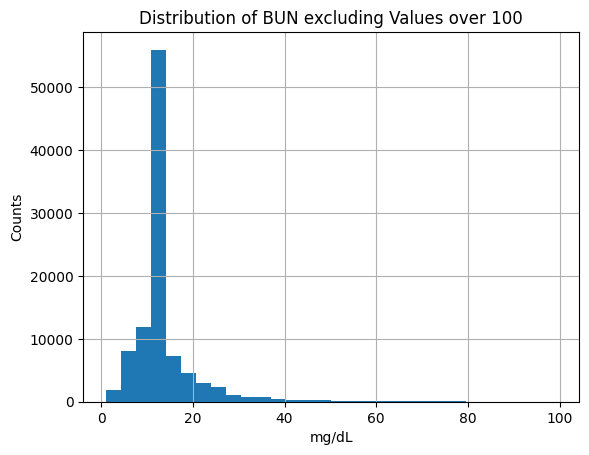

In [151]:
health_data_sort.bloodureanitro[health_data_sort.bloodureanitro < 100].hist(bins=30)
plt.xlabel('mg/dL')
plt.ylabel('Counts')
plt.title('Distribution of BUN excluding Values over 100');

The distrubution looks better if we take away values over 300, and even better if we remove values over 100.  Lets look at the correlation between BUN and renal failure in different groups of BUN levels to see if there is justification for removing light BUN rows.

In [ ]:
#Correlation in high but not insane BUN levels
BUN_med = health_data_sort[(health_data_sort['bloodureanitro'] > 100) & (health_data_sort['bloodureanitro'] < 300)]
print(BUN_med[['bloodureanitro', 'dialysisrenalendstage']].head(20))
print(len(BUN_med))
BUN_percent = len(BUN_med)/len(health_data_sort)*100
print(BUN_percent)
print(BUN_med['bloodureanitro'].corr(BUN_med['dialysisrenalendstage']))

       bloodureanitro dialysisrenalendstage
17959      159.500000                     0
54321      109.000000                     0
86932      104.000000                     1
45585      198.000000                     0
20554      275.333333                     0
16927      198.000000                     0
84447      219.000000                     0
39518      160.000000                     1
24759      107.000000                     1
49368      277.000000                     1
30797      142.500000                     1
13018      293.666667                     1
91932      104.000000                     1
93709      281.500000                     0
98709      281.500000                     0
82979      109.000000                     0
44522      107.000000                     0
4824       102.500000                     0
13475      218.500000                     0
9687       153.500000                     0
141
0.14100000000000001
-0.12537314077294123


In [144]:
#Correlation in reasonable levels
BUN_low = health_data_sort[(health_data_sort['bloodureanitro'] < 100)]
print(BUN_low[['bloodureanitro', 'dialysisrenalendstage']].head(20))
print(len(BUN_low))
BUN_percent = len(BUN_low)/len(health_data_sort)*100
print(BUN_percent)
print(BUN_low['bloodureanitro'].corr(BUN_low['dialysisrenalendstage']))

       bloodureanitro dialysisrenalendstage
82814            12.0                     0
99367            16.0                     0
91181             8.0                     0
83266             9.0                     0
2955             12.0                     0
66033             7.0                     0
1755             12.0                     0
36692            10.0                     0
79465            14.0                     0
93246             9.0                     0
73436            16.0                     0
55550            35.0                     0
5540             13.0                     0
19601            47.0                     1
72385            23.0                     0
22363            23.0                     0
16317            12.0                     0
7228             12.0                     0
71663            32.0                     0
7216             11.0                     0
99818
99.818
0.3614089387241811


In [ ]:
#Correlation in entire data set
health_data_sort['bloodureanitro'].corr(health_data_sort['dialysisrenalendstage'])

np.float64(0.2722393115783211)

Overall, 0.04% of patients have BUN over 300, and 0.14% of patients have BUN between 100 and 300.  Also, there in no correlation between renal failure and BUN levels above a BUN of 100, but there is small correlation in the rows with BUN under 100 and in the entire data set.  I will remove the rows with BUN above 300 as these levels seem impossible based on my limited research.

In [145]:
health_data_BUN = health_data_sort[health_data_sort['bloodureanitro'] <=300]

In [149]:
Neut_high = health_data_sort[health_data_sort['neutrophils'] > 50]
print(Neut_high[['neutrophils']].head())
print(Neut_high.shape)

       neutrophils
79663        139.8
18372        190.9
45420        207.6
11234        127.9
34066        105.3
(63, 29)


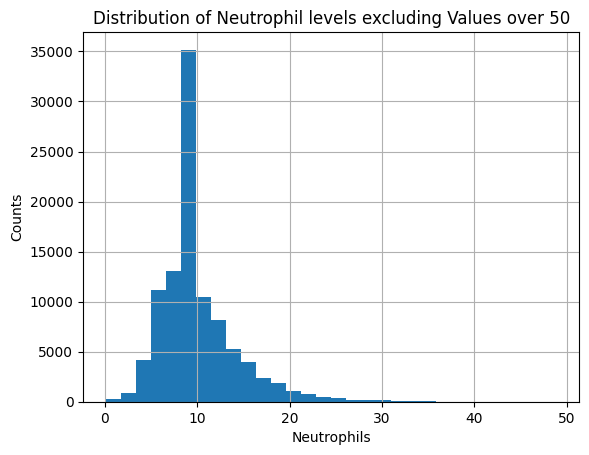

In [152]:
health_data_sort.neutrophils[health_data_sort.neutrophils < 50].hist(bins=30)
plt.xlabel('Neutrophils')
plt.ylabel('Counts')
plt.title('Distribution of Neutrophil levels excluding Values over 50');

There are 63 rows with neutorphils above 50.  Removing these values makes the distribution much mor normal.  For now, we will leave this data with an Orange Flag, as the units on this column are unclear and I can't find justification for removing very high levels, as these could be associated with neutrophenia.

## Save the Final Data File

In [153]:
# save the data to a new csv file
datapath = 'C:/Users/Ujval/OneDrive/Documents/GitHub/Springboard/Capstone_2'
save_file(health_data_BUN, 'LengthOfStay_data_cleaned.csv', datapath)

A file already exists with this name.

Writing file.  "C:/Users/Ujval/OneDrive/Documents/GitHub/Springboard/Capstone_2\LengthOfStay_data_cleaned.csv"


## Summary

In this notebook, I performed the data wrangling and cleaning for the LengthOfStay.csv dataset, which contains information on 100,000 patients admitted to the hospital for the purpose of predicting the length of their inpatient stay.

We found no missing values or duplicated rows in this dataset.  

The first pass over the dataset revealed three issues:  

- Categorical data columns were integer data types.  
  - Solved by changing data type to categorical  
  - Percent of True values was visualized for each, with no suspicious data detected.  
  - There is a disproportionate percentage of female patients in this dataset (56.5%).  

- Admission date column was an object data type due to extra characters.  
  - Non-numeric characters were removed and column was converted to datetime.  
  - Columns with the month and year of admission, respectively, were generated. Patient count and length of stay were visualized across months. No remarkable trends were observed.  

- Discharge date column is an object and also redundant.  
  - Discharge date column was removed.  

Descriptive statistics for all remaining numerical columns were performed, including visualization of the distributions. Blood urea nitrogen (BUN) and neutrophils stood out as having non-normal distributions around 0.  

- Normal BUN in healthy humans is 7-20 mg/dl with dangerous levels at 100+. The highest reported level I could find was 298. After some investigation of different stratifications of BUN in our dataset, it was decided to remove the 38 rows with BUN over 300. This was a conservative choice, as removing the additional 141 rows with BUN above 100 was also considered.  
  - BUN distribution was improved.  
  - BUN had no correlation with end stage renal failure in these rows, which does not make medical sense.  

- 63 rows were found to have neutrophil levels above 50, and the distribution was greatly improved in the remaining columns. However, this column was left with an orange flag and the rows were left in place since I could find no medical justification for removing them.  

The final, cleaned dataset was saved as `LengthOfStay_data_cleaned.csv`.